# Fashion MNIST w/ Convolutional Layers

In [1]:
# imports tons of things I will need for calculations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from statistics import mean
import random
import math
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision import datasets, transforms
from PIL import Image
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [2]:
def showImage(img):
    i = img.reshape((28, 28))
    plt.imshow(i, cmap="Greys")
    plt.show()

In [9]:
labelsMap = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [3]:
trainingData = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testData = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [7]:
print(len(trainingData), len(trainingData[0]), len(trainingData[0][0]), len(trainingData[0][0][0]), len(trainingData[0][0][0][0]))


60000 2 1 28 28


In [4]:
def putIntoArrays(data):
    images = [] # 60000 images w/ 784 pixels . (60000, 784)
    labels = [] # will be 60000 
    
    for i in range(len(data)):
        lab = data[i][1]
        image = data[i][0][0].reshape(784).tolist()
        
        images.append(image)
        labels.append(lab)
    
    images = torch.tensor(images)
    labels = torch.tensor(labels)
    return images, labels
        
trainImgs, trainLabel = putIntoArrays(trainingData)   
testImgs, testLabel = putIntoArrays(testData)
print(trainImgs.shape, trainLabel.shape)
print(testImgs.shape, testLabel.shape)

torch.Size([60000, 784]) torch.Size([60000])
torch.Size([10000, 784]) torch.Size([10000])


In [5]:
trainImgs_list = trainImgs.tolist()
trainLabel_list = trainLabel.tolist()
testImgs_list = testImgs.tolist()
testLabel_list = testLabel.tolist()

In [6]:
def batchANDrandom(images, labels, batchSize):
    indeces = []
    for i in range(len(images)):
        indeces.append(i)
    
    img = []
    lab = []
    for i in range(len(images)//batchSize):
        newImgs = []
        newLab = []
        for j in range(batchSize):
            index = random.randint(0, len(indeces)-1)
            val = indeces[index]
            indeces.pop(index)
            
            newImgs.append(images[val])
            newLab.append(labels[val])
        
        img.append(newImgs)
        lab.append(newLab)
    return img, lab
b_img_train, b_lab_train = batchANDrandom(trainImgs_list, trainLabel_list, 64)
b_img_test, b_lab_test = batchANDrandom(testImgs_list, testLabel_list, 64)

In [7]:
# convert to tensor
def tensorize(arr):
    nump = np.array(arr)
    tens = torch.tensor(nump)
    return tens

b_img_train = tensorize(b_img_train)
b_lab_train = tensorize(b_lab_train)
b_img_test = tensorize(b_img_test)
b_lab_test = tensorize(b_lab_test)

In [8]:
# images of type float
# labels of type long
imgTrain = b_img_train.float()
labTrain = b_lab_train.long()
imgTest = b_img_test.float()
labTest = b_lab_test.long()

### Building Network

In [13]:
# Building Network  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        #self.conv3 = nn.Conv3d(20, 30, kernel_size=5)
        #self.conv3_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        #x = F.relu(F.max_pool2d(self.conv2(x), 3))
        #x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 3))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        x = F.dropout(x, training=self.training)
        x = self.fc4(x)

        return F.log_softmax(x, dim=1)

In [14]:
# PREPARING Dataset

n_epochs = 20 # how many times we'll loop through training data
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # hyperparameter
momentum = 0.5 # hyperparameter
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
# Training model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(imgTrain) for i in range(n_epochs + 1)] # this is [0, 60000, 12000, 18000]

In [16]:
def train(epoch):
    network.train()
    for batch in range(len(imgTrain)):
        optimizer.zero_grad()
        temp = imgTrain[batch]
        temp = temp.reshape(64, 1, 28, 28)
        output = network(temp)
        loss = F.nll_loss(output, labTrain[batch])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_counter.append(
            (batch + 1) * len(imgTrain[batch]))
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch + 1) * len(imgTrain[batch]), len(imgTrain[batch]),
            100. * (batch + 1) / len(imgTrain), loss.item()))

        #torch.save(network.state_dict(), '/results/model.pth')
        #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [17]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in range(len(imgTest)):
            temp = imgTest[batch]
            temp = temp.reshape(64, 1, 28, 28)
            output = network(temp)
            test_loss += F.nll_loss(output, labTest[batch], size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(labTest[batch].data.view_as(pred)).sum()
        test_loss /= len(labTest)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, (len(labTest) * 64),
            100. * correct / (len(labTest) * 64)))

In [18]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/betinakreiman/opt/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 147.6256, Accuracy: 998/9984 (10%)

Train Epoch: 1 [64/64 (0%)]	Loss: 2.320824
Train Epoch: 1 [128/64 (0%)]	Loss: 2.314435
Train Epoch: 1 [192/64 (0%)]	Loss: 2.316535
Train Epoch: 1 [256/64 (0%)]	Loss: 2.305523
Train Epoch: 1 [320/64 (1%)]	Loss: 2.295939
Train Epoch: 1 [384/64 (1%)]	Loss: 2.307578
Train Epoch: 1 [448/64 (1%)]	Loss: 2.293953
Train Epoch: 1 [512/64 (1%)]	Loss: 2.308758
Train Epoch: 1 [576/64 (1%)]	Loss: 2.306816
Train Epoch: 1 [640/64 (1%)]	Loss: 2.298454
Train Epoch: 1 [704/64 (1%)]	Loss: 2.338690
Train Epoch: 1 [768/64 (1%)]	Loss: 2.304130
Train Epoch: 1 [832/64 (1%)]	Loss: 2.301400
Train Epoch: 1 [896/64 (1%)]	Loss: 2.316941
Train Epoch: 1 [960/64 (2%)]	Loss: 2.299762
Train Epoch: 1 [1024/64 (2%)]	Loss: 2.299443
Train Epoch: 1 [1088/64 (2%)]	Loss: 2.322637
Train Epoch: 1 [1152/64 (2%)]	Loss: 2.298557
Train Epoch: 1 [1216/64 (2%)]	Loss: 2.298691
Train Epoch: 1 [1280/64 (2%)]	Loss: 2.294511
Train Epoch: 1 [1344/64 (2%)]	Loss: 2.309066
Train Epoch: 

In [19]:
def predictingImage(img):
    img = img.reshape(1, 1, 28, 28)
    img = img.float()
    output = network(img)
    return output.data.max(1, keepdim=True)[1][0].item()
predictingImage(imgTrain[0][3])

4

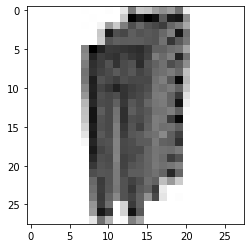

Coat Trouser


In [25]:
showImage(imgTrain[0][3])
print(labelsMap[4], labelsMap[labTrain[0][3].item()])

([-1.179063081741333, -1.3070363998413086, -1.8400843143463135, -1.8890665769577026, -2.836456060409546, -3.867436170578003, -4.047987937927246, -4.728667259216309, -5.725163459777832, -5.917529106140137], [4, 3, 6, 2, 0, 1, 8, 5, 9, 7])


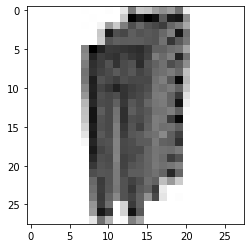

In [20]:
def predictingOutput(img):
    img = img.reshape(1, 1, 28, 28)
    img = img.float()
    output = network(img)
    outputs = []

    for i in range(10):
        outputs.append(output.data[0][i].item())
    return outputs
predictingOutput(imgTrain[0][3])

def rearrangeOutput(probabilities):
    #indeces = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    newProb = []
    numbers = []
    temp = probabilities
    minimum = min(probabilities) - 1
    for i in range(len(probabilities)):
        x = temp.index(max(temp))
        newProb.append(temp[x])
        temp[x] = minimum
        numbers.append(x)
    return newProb, numbers
imageTesting = imgTrain[0][3]
print(rearrangeOutput(predictingOutput(imageTesting)))
showImage(imageTesting)

In [33]:
# save for IOS Format

import torch
import torchvision
from torch.utils.mobile_optimizer import optimize_for_mobile
modelForIos = network
modelForIos.eval()
example = torch.rand(1, 1, 28, 28)
traced_script_module = torch.jit.trace(modelForIos, example)
torchscript_model_optimized = optimize_for_mobile(traced_script_module)
torchscript_model_optimized._save_for_lite_interpreter("../model/fashionModel.pt")

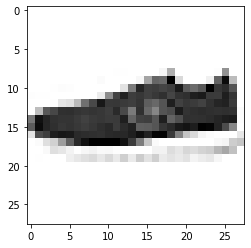

In [17]:
showImage(imgTrain[0][43])

In [18]:
print(imgTrain[0][43])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 